In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

In [23]:
funds = pd.read_csv('data/funds.csv')
funding_round = pd.read_csv('data/funding_rounds.csv')
investments = pd.read_csv('data/investments.csv')

In [24]:
funded_objects = pd.merge(investments, funding_round, left_on='funded_object_id', right_on='object_id', how='inner')
funded_objects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224597 entries, 0 to 224596
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id_x                      224597 non-null  int64  
 1   funding_round_id_x        224597 non-null  int64  
 2   funded_object_id          224597 non-null  object 
 3   investor_object_id        224597 non-null  object 
 4   created_at_x              224597 non-null  object 
 5   updated_at_x              224597 non-null  object 
 6   id_y                      224597 non-null  int64  
 7   funding_round_id_y        224597 non-null  int64  
 8   object_id                 224597 non-null  object 
 9   funded_at                 224368 non-null  object 
 10  funding_round_type        224597 non-null  object 
 11  funding_round_code        224597 non-null  object 
 12  raised_amount_usd         224597 non-null  float64
 13  raised_amount             224597 non-null  f

In [25]:
selected_columns = ['raised_amount_usd', 'funded_at', 'funding_round_id_x']

investments_df = funded_objects[selected_columns]


In [29]:
from sklearn.impute import KNNImputer
from datetime import datetime

investments_df['funded_at'] = pd.to_datetime(investments_df['funded_at'])

# Impute missing dates with a placeholder date (e.g., the earliest date in the dataset)
placeholder_date = investments_df['funded_at'].min()
investments_df['funded_at_imputed'] = investments_df['funded_at'].fillna(placeholder_date)

# Convert datetime values to ordinal representation (numeric values)
investments_df['funded_at_ordinal'] = investments_df['funded_at_imputed'].apply(lambda x: x.toordinal())

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Impute missing ordinal values
investments_df['imputed_funded_at_ordinal'] = imputer.fit_transform(investments_df[['funded_at_ordinal']])

# Convert imputed ordinal values back to datetime
investments_df['imputed_funded_at'] = investments_df['imputed_funded_at_ordinal'].apply(lambda x: datetime.fromordinal(int(x)))

# Drop temporary columns
investments_df.drop(columns=['funded_at_imputed', 'funded_at_ordinal', 'imputed_funded_at_ordinal'], inplace=True)

investments_df.set_index('imputed_funded_at', inplace=True)

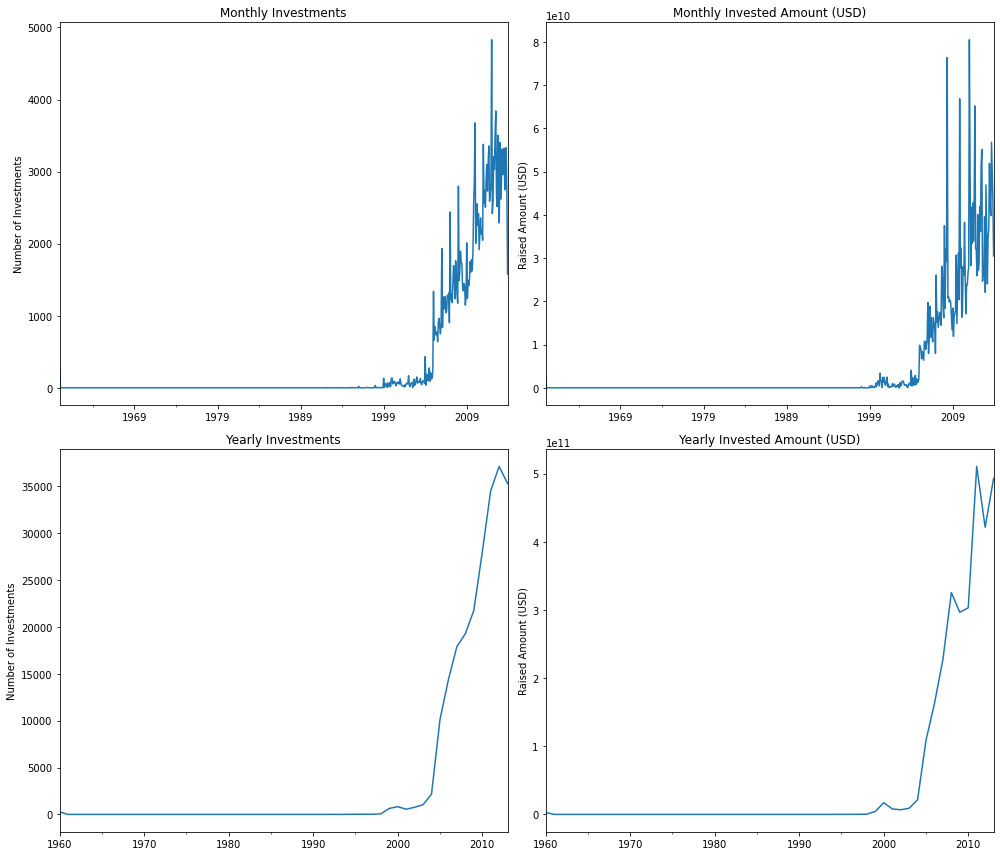

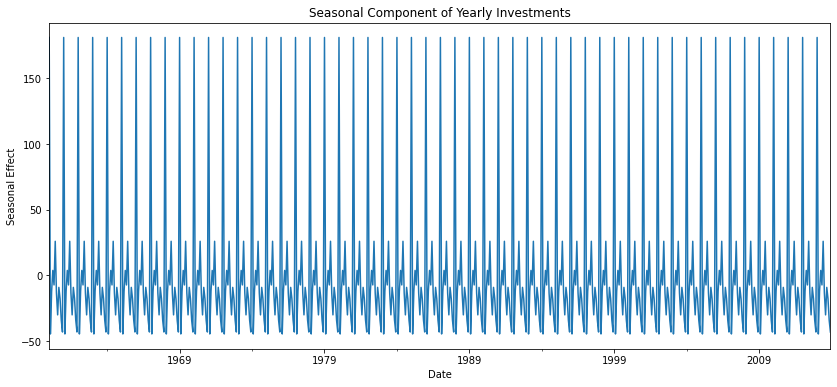

In [34]:


monthly_investments = investments_df['raised_amount_usd'].resample('M').count()
yearly_investments = investments_df['raised_amount_usd'].resample('Y').count()

monthly_invested_amount = investments_df['raised_amount_usd'].resample('M').sum()
yearly_invested_amount = investments_df['raised_amount_usd'].resample('Y').sum()

# Plotting in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Adjusted for a 2x2 grid

# Plot each time series in its own subplot
monthly_investments.plot(ax=axes[0, 0], title='Monthly Investments')
monthly_invested_amount.plot(ax=axes[0, 1], title='Monthly Invested Amount (USD)')
yearly_investments.plot(ax=axes[1, 0], title='Yearly Investments')
yearly_invested_amount.plot(ax=axes[1, 1], title='Yearly Invested Amount (USD)')
decomposition = seasonal_decompose(monthly_investments, model='additive')

# Setting the labels for x and y axes
axes[0, 0].set(xlabel='', ylabel='Number of Investments')
axes[0, 1].set(xlabel='', ylabel='Raised Amount (USD)')
axes[1, 0].set(xlabel='', ylabel='Number of Investments')
axes[1, 1].set(xlabel='', ylabel='Raised Amount (USD)')

plt.tight_layout()
plt.show()

# Plotting the seasonal component
plt.figure(figsize=(14, 6))
decomposition.seasonal.plot(title='Seasonal Component of Yearly Investments')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()


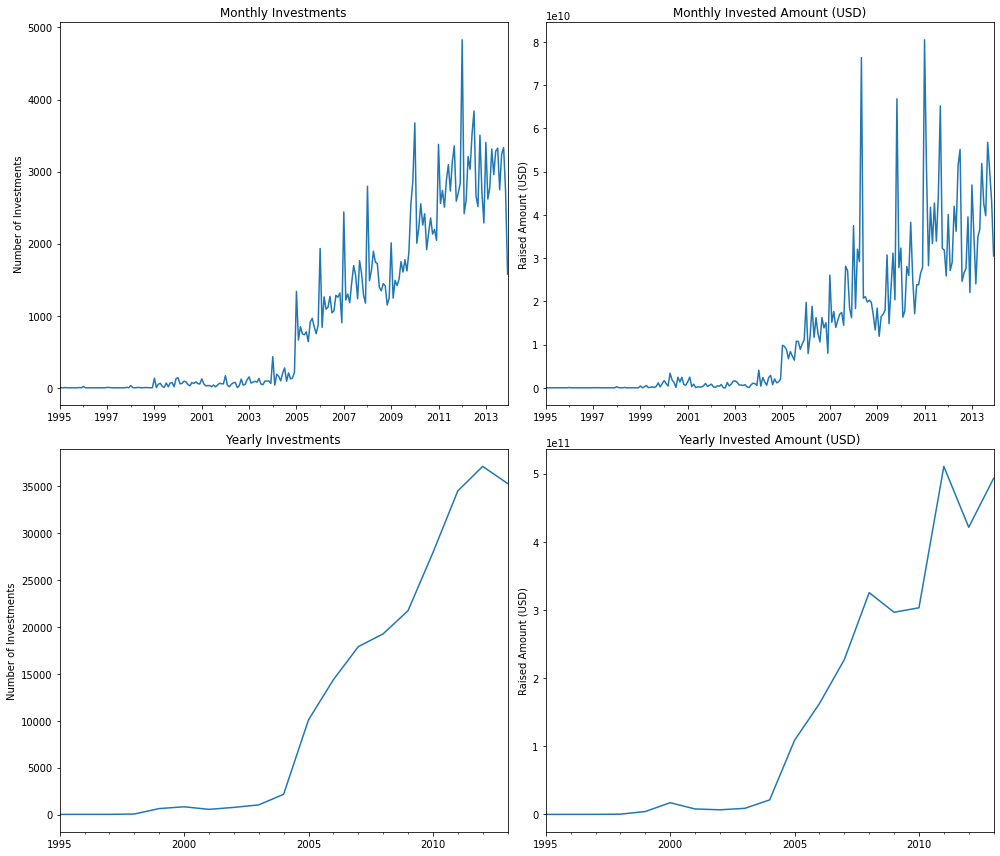

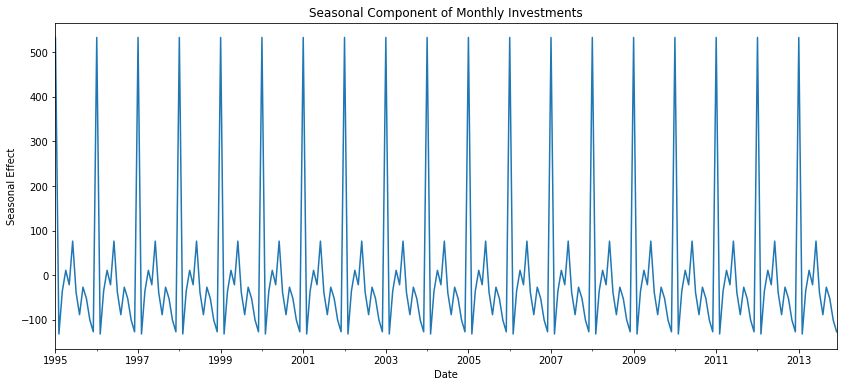

In [36]:
# Set the start date to January 1, 1995
start_date = '1995-01-01'

# Resample the data starting from 1995
monthly_investments = investments_df.loc[start_date:, 'raised_amount_usd'].resample('M').count()
yearly_investments = investments_df.loc[start_date:, 'raised_amount_usd'].resample('Y').count()

monthly_invested_amount = investments_df.loc[start_date:, 'raised_amount_usd'].resample('M').sum()
yearly_invested_amount = investments_df.loc[start_date:, 'raised_amount_usd'].resample('Y').sum()

# Plotting in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Adjusted for a 2x2 grid

# Plot each time series in its own subplot
monthly_investments.plot(ax=axes[0, 0], title='Monthly Investments')
monthly_invested_amount.plot(ax=axes[0, 1], title='Monthly Invested Amount (USD)')
yearly_investments.plot(ax=axes[1, 0], title='Yearly Investments')
yearly_invested_amount.plot(ax=axes[1, 1], title='Yearly Invested Amount (USD)')
decomposition = seasonal_decompose(monthly_investments, model='additive')

# Setting the labels for x and y axes
axes[0, 0].set(xlabel='', ylabel='Number of Investments')
axes[0, 1].set(xlabel='', ylabel='Raised Amount (USD)')
axes[1, 0].set(xlabel='', ylabel='Number of Investments')
axes[1, 1].set(xlabel='', ylabel='Raised Amount (USD)')

plt.tight_layout()
plt.show()

# Plotting the seasonal component
plt.figure(figsize=(14, 6))
decomposition.seasonal.plot(title='Seasonal Component of Monthly Investments')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()


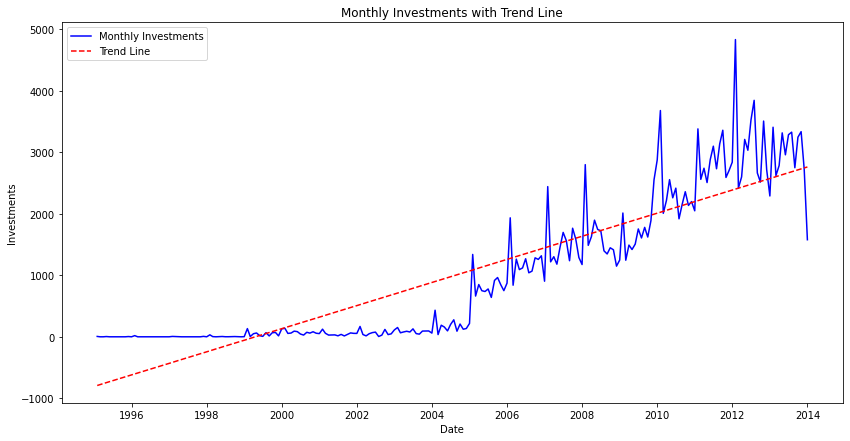

(15.641016749402896, 6.721337235413134e-79)

In [45]:
# Extracting numerical indices for linear regression
x = np.arange(len(monthly_investments))
y = monthly_investments.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate values for the trend line
trend_line = intercept + slope * x 

# Plotting the monthly messages with the trend line
plt.figure(figsize=(14, 7))
plt.plot(monthly_investments.index, monthly_investments, label='Monthly Investments', color='blue')
plt.plot(monthly_investments.index, trend_line, label='Trend Line', color='red', linestyle='--')
plt.title('Monthly Investments with Trend Line')
plt.xlabel('Date')
plt.ylabel('Investments')
plt.legend()
plt.show()

# Returning the slope and p-value to interpret the trend and its statistical significance
slope, p_value

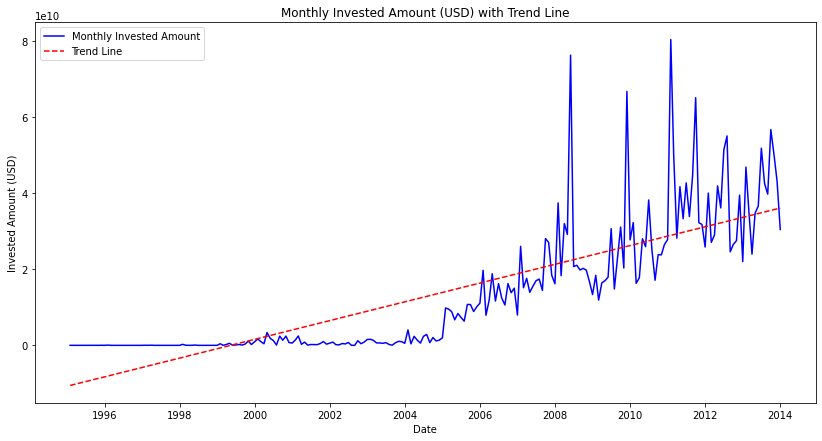

(205752516.58082604, 2.9085808539920355e-56)

In [47]:
# Extracting numerical indices for linear regression
x = np.arange(len(monthly_invested_amount))
y = monthly_invested_amount.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate values for the trend line
trend_line = intercept + slope * x 

# Plotting the monthly messages with the trend line
plt.figure(figsize=(14, 7))
plt.plot(monthly_invested_amount.index, monthly_invested_amount, label='Monthly Invested Amount', color='blue')
plt.plot(monthly_invested_amount.index, trend_line, label='Trend Line', color='red', linestyle='--')
plt.title('Monthly Invested Amount (USD) with Trend Line')
plt.xlabel('Date')
plt.ylabel('Invested Amount (USD)')
plt.legend()
plt.show()

# Returning the slope and p-value to interpret the trend and its statistical significance
slope, p_value